# Projet Leyenda : Livrable 1

### Groupe 2 :
- Brenda DJIGUEMDE
- Bruno DIAS
- Romaric DEMBELE
- Dany KHADAR

## Contexte


TouNum est une entreprise de numérisation de documents (textes, images...) et elle est souvent sollicitée par d'autres entreprises pour numériser leur base de documents papier. Certains de leurs clients ont une grande quantité de données à numériser, et un service de catégorisation automatique serait plus que valorisable. L'entreprise nous fait appel pour travailler sur une solution visant à analyser des photographies pour en déterminer une légende descriptive de manière automatique (du captioning).

Ceci dit, il y a deux challenges à relever, en plus de cet étiquetage proprement dit. Tout d'abord, la numérisation se faisant à la chaîne et sur des images de qualité variable (parfois floues, ou bruitées), il faudra tout d'abord voir ce qu'on peut faire pour nettoyer ces images. Et puis, TouNum a déjà numérisé beaucoup de documents sur lesquels ils souhaitent faire tourner les algorithmes d'apprentissage que nous allons concevoir. Or, Certaines de ces images ne sont pas des photos, mais parfois des images de documents composés, ou des schémas, voire des dessins ou des peintures. Il faudrait donc qu'on puisse, en amont de l'analyse de contenu, faire le tri entre les photos et le reste.

Heureusement, Tounum a déjà quelques milliers d'images catégorisées et étiquetées. Voilà qui devrait être utile pour effectuer de l'apprentissage supervisé.

## Objectif du livrable


L'entreprise voulant automatiser la sélection de photos pour l'annotations, ce livrable fournira une méthode de classification se basant sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos du dataset de départ. La solution s'appuyera sur l'architecture de réseau de neurones que nous aurons choisi et justifié notamment du point de vue des résultats obtenus.

TouNum a déjà classé un certain nombre d'images, nous aurons donc un dataset d'images catégorisées pour entraîner votre réseau de neurones.

## 1. Chargement des données et consitution du jeu de données

In [96]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Layer
from tensorflow.keras import Sequential

In [97]:
# Dataset parameters
image_size = (64, 64)
batch_size = 16
dataset_path = './dataset_livrable_1'

# Load the dataset
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,  
    label_mode='int'  # Assurez-vous que les labels sont des entiers
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'  # Assurez-vous que les labels sont des entiers
)

Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Found 41398 files belonging to 5 classes.
Using 8279 files for validation.


In [98]:
class_names = train_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


In [99]:
# Verify classes distribution
import numpy as np

class_counts = np.zeros(len(class_names))

for images, labels in train_set:
    for label in labels:
        class_counts[label.numpy()] += 1

# Printing class distribution
for class_name, count in zip(class_names, class_counts):
    print(f"{class_name}: {count}")

In [ ]:
class_counts = np.zeros(len(class_names))

for images, labels in test_set:
    for label in labels:
        class_counts[label.numpy()] += 1

# Printing class distribution
for class_name, count in zip(class_names, class_counts):
    print(f"{class_name}: {count}")

Painting: 2031.0
Photo: 2047.0
Schematics: 1955.0
Sketch: 288.0
Text: 1958.0


In [ ]:
# Nom du dossier cible, par exemple 'photo'
target_folder_name = 'Photo'

# Trouver l'index du label basé sur le nom du dossier
target_label = train_set.class_names.index(target_folder_name)

def binary_label(images, labels):
    """Fonction pour convertir les étiquettes en format binaire."""
    binary_labels = tf.where(labels == target_label, 1, 0)
    return images, binary_labels

# Appliquer la fonction de prétraitement aux jeux de données
train_set = train_set.map(binary_label)
test_set = test_set.map(binary_label)

print(train_set)
print(test_set)

<_MapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
for images, labels in train_set.take(1):
    print(labels)

tf.Tensor([1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0], shape=(16,), dtype=int32)


In [ ]:
# # Nombre d'exemples à conserver dans le buffer pour le mélange
# buffer_size = 100

# # Appliquer le mélange au jeu de données d'entraînement
# train_set = train_set.shuffle(buffer_size)

# # Appliquer le mélange au jeu de données de test
# # Note : Généralement, le mélange de l'ensemble de test n'est pas nécessaire, mais vous pouvez choisir de le faire.
# test_set = test_set.shuffle(buffer_size)

## 2. Visualisation des données

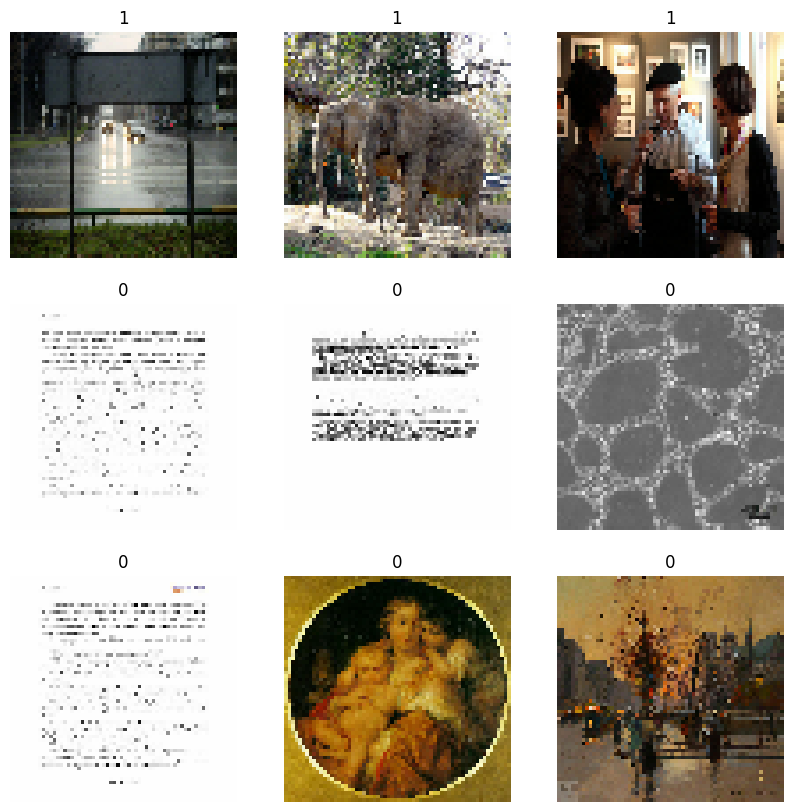

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")

## 3. Configuration de l'environnement pour l'entrainement

In [ ]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE

#train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_set = train_set.map(lambda x, y: (normalization_layer(x), y))
test_set = test_set.map(lambda x, y: (normalization_layer(x), y))

## 5. Le modèle de réseau de neurones convolutif (CNN)

In [ ]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    # Data augmentation
    # x = data_augmentation(inputs)
    # Normalizing
    # x = normalization_layer(x)
    # Convolutional base
    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    # x = Conv2D(128, 3, activation='relu')(x)
    # x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
model = create_model((64, 64, 3))
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(train_set, epochs=10, validation_data=test_set)

Epoch 1/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 130s 62ms/step - accuracy: 0.8121 - loss: 0.3645 - val_accuracy: 0.8623 - val_loss: 0.2883
Epoch 2/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 117s 56ms/step - accuracy: 0.8777 - loss: 0.2608 - val_accuracy: 0.8971 - val_loss: 0.2361
Epoch 3/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 120s 58ms/step - accuracy: 0.9063 - loss: 0.2114 - val_accuracy: 0.8985 - val_loss: 0.2451
Epoch 4/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 117s 57ms/step - accuracy: 0.9298 - loss: 0.1673 - val_accuracy: 0.9004 - val_loss: 0.2668
Epoch 5/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 109s 53ms/step - accuracy: 0.9494 - loss: 0.1252 - val_accuracy: 0.9035 - val_loss: 0.3033
Epoch 6/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 109s 53ms/step - accuracy: 0.9679 - loss: 0.0847 - val_accuracy: 0.8990 - val_loss: 0.3618
Epoch 7/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 109s 53ms/step - accuracy: 0.9783 - loss: 0.0600 - val_accuracy: 0.8937 - val_loss: 0.4576
Epoch 8/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 114s 55ms/step - accuracy: 

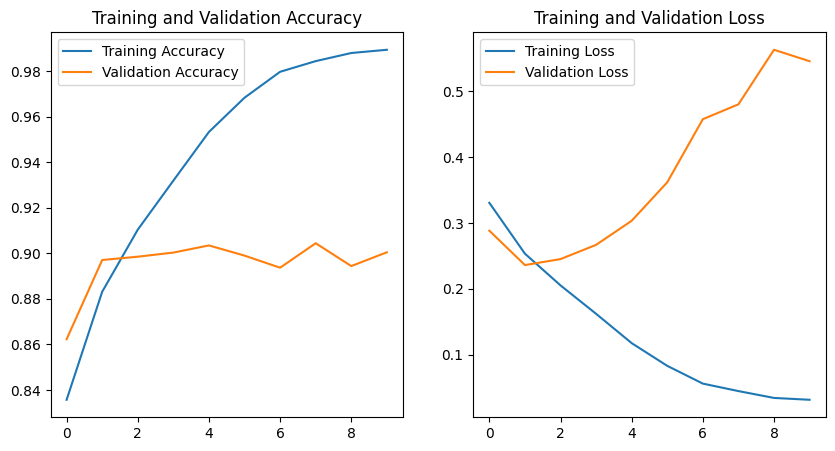

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
for images, labels in test_set.take(5):
    preds = model.predict(images)
    print("Predictions:", preds)
    print("Actual labels:", labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predictions: [[0.00351432]
 [0.4605488 ]
 [0.46207586]
 [0.4635904 ]
 [0.00354841]
 [0.4643949 ]
 [0.00455953]
 [0.4627666 ]
 [0.00346758]
 [0.00352413]
 [0.4621611 ]
 [0.463039  ]
 [0.0040821 ]
 [0.27925766]
 [0.46093175]
 [0.00996227]]
Actual labels: [0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predictions: [[0.00777196]
 [0.17098252]
 [0.00356586]
 [0.11108682]
 [0.00379057]
 [0.01833204]
 [0.00345373]
 [0.46203578]
 [0.46184695]
 [0.4629731 ]
 [0.4632583 ]
 [0.46096587]
 [0.4632216 ]
 [0.46440667]
 [0.00373165]
 [0.00442503]]
Actual labels: [0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predictions: [[0.3142394 ]
 [0.4613922 ]
 [0.00368659]
 [0.02425114]
 [0.4614707 ]
 [0.42395678]
 [0.00345858]
 [0.46522933]
 [0.4619821 ]
 [0.4649568 ]
 [0.4646549 ]
 [0.01459029]
 [0.00368021]
 [0.46231505]
 [0.00360649]
 [0.0035469 ]]
Actual labels: [0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

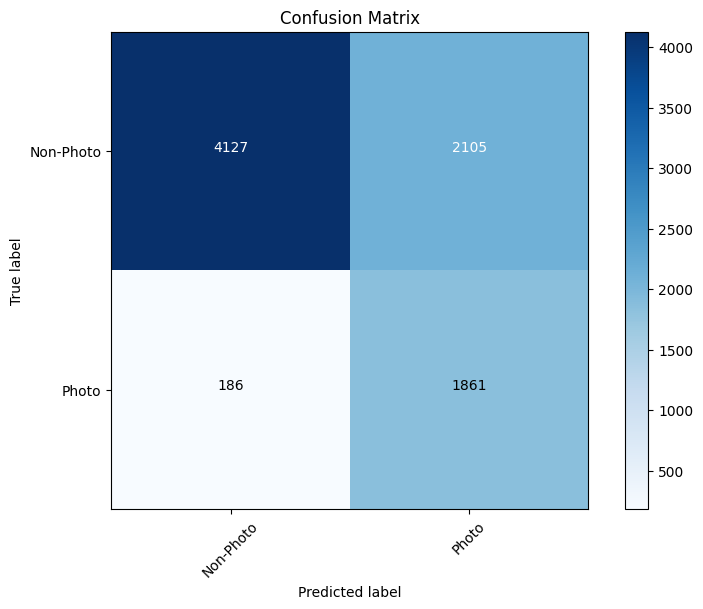

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Faire des prédictions sur l'ensemble de test
y_pred_prob = []
y_true = []
for images, labels in test_set:
    # Obtenez les prédictions sous forme de probabilités
    preds = model.predict(images)
    y_pred_prob.extend(preds)
    y_true.extend(labels.numpy().astype(int))

# Fonction pour calculer et afficher la matrice de confusion
def calculate_and_plot_confusion_matrix(y_true, y_pred_prob, threshold, class_names):
    # Convertissez les probabilités en prédictions basées sur le seuil
    y_pred_adjusted = (np.array(y_pred_prob) > threshold).astype(int)

    # Recalculez la matrice de confusion avec le nouveau seuil
    new_cm = confusion_matrix(y_true, y_pred_adjusted)

    # Affichez la nouvelle matrice de confusion
    plot_confusion_matrix(new_cm, class_names)

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, class_names):
    """
    Affiche une matrice de confusion avec une coloration spécifique et des annotations.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Ajouter des annotations de texte à l'intérieur de la matrice
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Choisissez un seuil pour tester
threshold = 0.3  # Ajustez ce seuil selon les besoins pour votre modèle

# Calculer et afficher la matrice de confusion avec le seuil ajusté
calculate_and_plot_confusion_matrix(y_true, y_pred_prob, threshold, class_names=['Non-Photo', 'Photo'])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calculer les métriques en utilisant le seuil ajusté pour la classification binaire
def calculate_metrics(y_true, y_pred_prob, threshold):
    # Convertissez les probabilités en prédictions binaires basées sur le seuil
    y_pred_adjusted = (np.array(y_pred_prob) > threshold).astype(int)

    # Calculer les métriques
    precision = precision_score(y_true, y_pred_adjusted)
    recall = recall_score(y_true, y_pred_adjusted)
    f1 = f1_score(y_true, y_pred_adjusted)
    # Calcul de l'AUC nécessite les scores de probabilité, pas les prédictions binaires
    auc = roc_auc_score(y_true, y_pred_prob)

    return precision, recall, f1, auc

# Ajuster le seuil de classification si nécessaire
threshold = 0.45

# Calculer les métriques
precision, recall, f1, auc = calculate_metrics(y_true, y_pred_prob, threshold)

# Afficher les métriques
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Precision: 0.4722
Recall: 0.8217
F1 Score: 0.5998
AUC: 0.8457


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 143s 69ms/step - accuracy: 0.7536 - loss: 8.1606 - val_accuracy: 0.7527 - val_loss: 2.4228
Epoch 2/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 151s 73ms/step - accuracy: 0.7625 - loss: 2.4148 - val_accuracy: 0.7527 - val_loss: 2.4234
Epoch 3/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 153s 74ms/step - accuracy: 0.7630 - loss: 2.4019 - val_accuracy: 0.7527 - val_loss: 2.4260
Epoch 4/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 155s 75ms/step - accuracy: 0.7631 - loss: 2.3904 - val_accuracy: 0.7527 - val_loss: 2.3918
Epoch 5/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 142s 68ms/step - accuracy: 0.7626 - loss: 2.3879 - val_accuracy: 0.7527 - val_loss: 2.4139
Epoch 6/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 146s 70ms/step - accuracy: 0.7630 - loss: 2.3841 - val_accuracy: 0.7527 - val_loss: 2.4041
Epoch 7/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.7630 - loss: 2.3851 - val_accuracy: 0.7527 - val_loss: 2.4182
Epoch 8/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 136s 66ms/step - accuracy: 

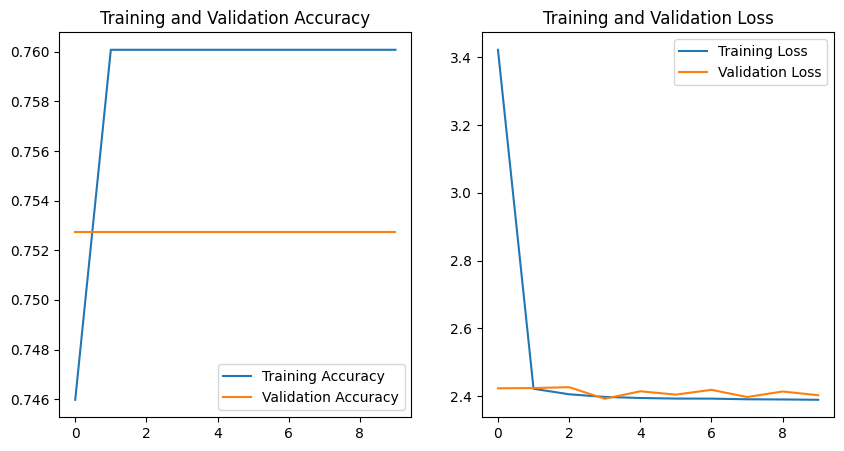

In [ ]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    # Data augmentation
    # x = data_augmentation(inputs)
    # Normalizing
    # x = normalization_layer(x)
    # Convolutional base
    x = Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(x)
    x = MaxPooling2D()(x)
    # x = Conv2D(128, 3, activation='relu')(x)
    # x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model_l1_l2 = Model(inputs, outputs)
    return model_l1_l2

model_l1_l2 = create_model((64, 64, 3))
model_l1_l2.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

model_l1_l2.summary()

# Train the model
history = model_l1_l2.fit(train_set, epochs=10, validation_data=test_set)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calculer les métriques en utilisant le seuil ajusté pour la classification binaire
def calculate_metrics(y_true, y_pred_prob, threshold):
    # Convertissez les probabilités en prédictions binaires basées sur le seuil
    y_pred_adjusted = (np.array(y_pred_prob) > threshold).astype(int)

    # Calculer les métriques
    precision = precision_score(y_true, y_pred_adjusted)
    recall = recall_score(y_true, y_pred_adjusted)
    f1 = f1_score(y_true, y_pred_adjusted)
    # Calcul de l'AUC nécessite les scores de probabilité, pas les prédictions binaires
    auc = roc_auc_score(y_true, y_pred_prob)

    return precision, recall, f1, auc

# Ajuster le seuil de classification si nécessaire
threshold = 0.3

# Calculer les métriques
precision, recall, f1, auc = calculate_metrics(y_true, y_pred_prob, threshold)

# Afficher les métriques
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Precision: 0.4692
Recall: 0.9091
F1 Score: 0.6190
AUC: 0.8457


In [ ]:
def confusion_matrix_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = confusion_matrix_metrics(cm)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7527479164150259
Precision: nan
Recall: 0.0
F1 Score: nan


C:\Users\danyk\AppData\Local\Temp\ipykernel_4852\2399258902.py:4: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [ ]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    # Data augmentation
    # x = data_augmentation(inputs)
    # Normalizing
    # x = normalization_layer(x)
    # Convolutional base
    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    # x = Conv2D(128, 3, activation='relu')(x)
    # x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

model = create_model((64, 64, 3))
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(train_set, epochs=10, validation_data=test_set)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=2, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = create_model((64, 64, 3))
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(train_set, epochs=10, validation_data=test_set, callbacks=[early_stopping])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()    

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
//Fais le model L2 + dropout

def create_model(input_shape):
    inputs = Input(shape=input_shape)
    # Data augmentation
    # x = data_augmentation(inputs)
    # Normalizing
    # x = normalization_layer(x)
    # Convolutional base
    x = Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = MaxPooling2D()(x)
    # x = Conv2D(128, 3, activation='relu')(x)
    # x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

model = create_model((64, 64, 3))
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(train_set, epochs=10, validation_data=test_set)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Dans ce projet, nous allons créer un modèle de classification binaire pour TouNum, une entreprise de stockage de photos en ligne. L'objectif est de distinguer les photos des autres types d'images, telles que les logos, les illustrations, etc. Pour ce faire, nous allons utiliser un réseau de neurones convolutionnels (CNN) avec TensorFlow, une bibliothèque open-source de machine learning.


Implémenatation de TensorFlow, SciKit, Pandas, ImageIO, NumPy, et MatPlotLib.


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical

Décris comment charger et explorer le dataset d'images fourni par TouNum, en utilisant ImageIO et Pandas. Explique comment visualiser des échantillons d'images de chaque catégorie (photos, peintures, schémas, textes scannés, portraits dessinés) et comment préparer ces images pour le processus d'apprentissage, incluant le redimensionnement et la normalisation.


In [ ]:
import os
import pandas as pd
import imageio
import random

def load_images_and_labels(directory, categories, samples_per_category=3000):
    images = []
    labels = []

    for category in categories:
        category_directory = os.path.join(directory, category)
        filenames = os.listdir(category_directory)
        filenames = filenames[:samples_per_category]  # Charger les premiers échantillons
        for filename in filenames:
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(category_directory, filename)
                img = imageio.imread(image_path)
                images.append(img)
                labels.append(category if category == "Photo" else "Non photo")
    return images, labels

# Définir le répertoire où se trouvent les données d'images
directory = '.'

# Définir les catégories d'images disponibles
categories = ['Painting', 'Schematics', 'Sketch', 'Text', 'Photo']

# Charger les images et leurs étiquettes à partir des répertoires de catégories
images, labels = load_images_and_labels(directory, categories)

# Mélanger les échantillons de manière aléatoire
combined = list(zip(images, labels))
random.shuffle(combined)
images[:], labels[:] = zip(*combined)

# Créer un DataFrame pandas contenant les images et leurs étiquettes
data = pd.DataFrame({'image': images, 'label': labels})

# Afficher quelques échantillons d'images de chaque catégorie
display_samples_per_category = 5  # Nombre d'échantillons à afficher par catégorie
fig, axes = plt.subplots(2, display_samples_per_category, figsize=(20, 5))
for i, category in enumerate(["Photo", "Non photo"]):
    category_data = data[data['label'] == category][:display_samples_per_category]  # Sélectionner les premiers échantillons de la catégorie
    for j in range(display_samples_per_category):
        ax = axes[i, j]
        if j < len(category_data):  # Vérifier si l'index est valide
            ax.imshow(category_data['image'].iloc[j])
            ax.axis('off')
            ax.set_title(category)
        else:
            ax.axis('off')  # Masquer l'axe s'il n'y a pas d'image à afficher
plt.show()


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '.\\Painting'

In [ ]:
import numpy as np
import tensorflow as tf
from scipy.ndimage import median_filter

def prepare_images(data, image_size=(64, 64), convert_to_grayscale=False):
    X = []
    for img in data['image']:
        img = np.array(img)  # Convertir en ndarray si ce n'est pas déjà le cas
        
        # Convertir en niveaux de gris si spécifié
        if convert_to_grayscale:
            img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
            img = np.expand_dims(img, axis=-1)  # Ajouter une dimension de canal
            
        if len(img.shape) == 2:  # Si l'image est en niveaux de gris, ajouter une dimension de canal
            img = np.expand_dims(img, axis=-1)
        elif len(img.shape) == 3 and img.shape[-1] == 4:  # Si l'image est en RGBA, supprimer le canal alpha
            img = img[..., :3]
        
        # Redimensionner l'image
        img = tf.image.resize(img, image_size)
        X.append(img)
    
    max_height = max(img.shape[0] for img in X)
    max_width = max(img.shape[1] for img in X)
    resized_X = []
    for img in X:
        resized_img = np.zeros((max_height, max_width, 3))
        resized_img[:img.shape[0], :img.shape[1]] = img
        resized_X.append(resized_img)
    
    X = np.stack(resized_X) / 255.0  # Normaliser les valeurs de pixel à l'échelle [0, 1]
    return X

# Préparer les images pour l'apprentissage
X = prepare_images(data)
y = data['label'].values

# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

num_data = data.shape[0]  # Récupérer le nombre de lignes
print("Nombre total d'échantillons dans le DataFrame :", num_data)
# Afficher les dimensions des ensembles de données
print('Dimensions des ensembles de données:')
print('Ensemble d\'apprentissage:', X_train.shape, y_train.shape)
print('Ensemble de test:', X_test.shape, y_test.shape)

Nombre total d'échantillons dans le DataFrame : 13405
Dimensions des ensembles de données:
Ensemble d'apprentissage: (10724, 64, 64, 3) (10724,)
Ensemble de test: (2681, 64, 64, 3) (2681,)


Fournis un guide détaillé pour concevoir l'architecture d'un réseau de neurones convolutif (CNN) en utilisant TensorFlow pour la tâche de classification binaire. Explique le choix des couches, le nombre de neurones, les fonctions d'activation, et comment structurer le modèle pour distinguer efficacement les photos des autres types d'images.

In [ ]:
# Créer un modèle CNN
# La Sequential est une classe de modèle permettant de créer des modèles séquentiels couche par couche.
model = Sequential([
    # Première couche convolutionnelle avec 16 filtres de taille (3, 3) et activation ReLU
    # Cette couche extrait des caractéristiques de bas niveau des images en appliquant des filtres de convolution.
    Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    # Couche de pooling pour réduire la dimensionnalité de la sortie de la couche convolutive
    # Elle réduit la taille spatiale des représentations, ce qui réduit le nombre de paramètres et de calculs dans le réseau.
    MaxPooling2D((2, 2)),
    # Deuxième couche convolutionnelle avec 32 filtres de taille (3, 3) et activation ReLU
    # Cette couche extrait des caractéristiques de niveau supérieur en combinant les caractéristiques de bas niveau.
    Conv2D(32, (3, 3), activation='relu'),
    # Nouvelle couche de pooling pour réduire encore la dimensionnalité
    # Elle permet de maintenir les caractéristiques les plus importantes tout en réduisant la taille de l'entrée.
    MaxPooling2D((2, 2)),
    # Aplatir la sortie pour la connexion à une couche dense
    # Elle transforme les matrices de caractéristiques en un vecteur unidimensionnel pour la classification.
    Flatten(),
    # Couche dense avec 128 neurones et activation ReLU
    # Cette couche apprend des combinaisons linéaires de caractéristiques pour la classification.
    Dense(128, activation='relu'),
    Dense(len(categories), activation='softmax')
])

c:\Users\danyk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4. Compilation et Entraînement du Modèle
"Explique comment compiler le modèle en choisissant une fonction de perte appropriée et un optimiseur (par exemple, Adam). Détaille comment configurer les paramètres d'entraînement, comme le taux d'apprentissage, et comment utiliser les datasets d'entraînement et de test pour entraîner le modèle. Inclut également la manière de suivre l'évolution de l'erreur d'entraînement, de l'erreur de validation et de l'accuracy."

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7721 - loss: 0.4485 - val_accuracy: 0.8364 - val_loss: 0.3377
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8471 - loss: 0.3094 - val_accuracy: 0.8392 - val_loss: 0.3157
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8770 - loss: 0.2696 - val_accuracy: 0.8681 - val_loss: 0.2963
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8932 - loss: 0.2375 - val_accuracy: 0.8643 - val_loss: 0.2814
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9020 - loss: 0.2188 - val_accuracy: 0.8592 - val_loss: 0.2973
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9281 - loss: 0.1734 - val_accuracy: 0.8639 - val_loss: 0.3004
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9364 - loss: 0.1560 - val_accuracy: 0.8559 - val_loss: 0.3344
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9474 - loss: 0.1415 - val_accu

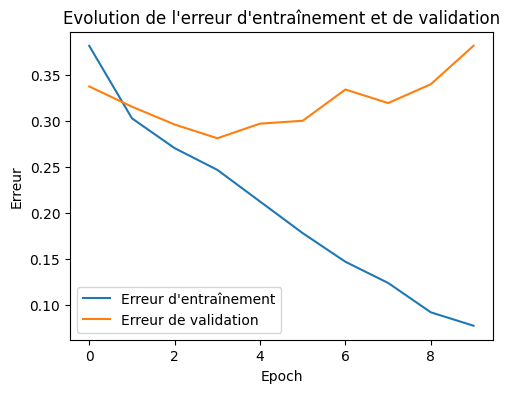

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Créer un LabelEncoder pour convertir les étiquettes en entiers
label_encoder = LabelEncoder()

# Convertir les étiquettes en entiers
y_train_int = label_encoder.fit_transform(y_train)
y_test_int = label_encoder.transform(y_test)

# Encodage des étiquettes entières pour la classification multiclasse
y_train_encoded = to_categorical(y_train_int, num_classes=len(categories))
y_test_encoded = to_categorical(y_test_int, num_classes=len(categories))

# Compilation du modèle avec la perte et la métrique appropriées
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les données encodées
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Affichage de l'évolution de l'erreur d'entraînement et de validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Erreur d\'entraînement')
plt.plot(history.history['val_loss'], label='Erreur de validation')
plt.xlabel('Epoch')
plt.ylabel('Erreur')
plt.legend()
plt.title('Evolution de l\'erreur d\'entraînement et de validation')
plt.show()

5. Évaluation du Modèle et Analyse des Résultats
"Présente un guide pour évaluer les performances du modèle sur le dataset de test, incluant la visualisation de l'accuracy et la perte. Analyse les résultats obtenus, discute le compromis entre biais et variance, et identifie si le modèle souffre de sur-apprentissage ou de sous-apprentissage."

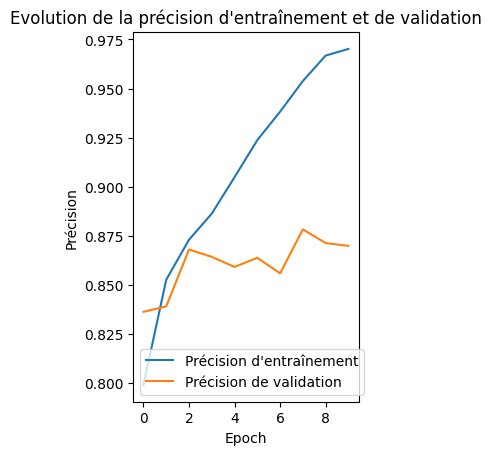

In [ ]:

# Afficher l'évolution de la précision d'entraînement et de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Précision de validation')
plt.xlabel('Epoch')
plt.ylabel('Précision')
plt.legend()
plt.title('Evolution de la précision d\'entraînement et de validation')
plt.show()



Précision de l'entraînement :

La précision de l'entraînement semble augmenter progressivement au fil des époques, passant d'environ 51% à près de 97%. Cela indique que le modèle s'améliore à ajuster les données d'entraînement au fur et à mesure de l'apprentissage.
Précision de la validation :

La précision de la validation varie autour de 73% à 83% au cours des époques. Cela montre que le modèle fonctionne bien sur les données de validation, mais il y a une légère fluctuation.
Comparaison entre précision d'entraînement et de validation :

La précision de l'entraînement est nettement plus élevée que celle de la validation, ce qui indique un écart entre les performances sur les données d'entraînement et de validation.
Évolution de l'erreur :

L'erreur d'entraînement diminue régulièrement au fil des époques, tandis que l'erreur de validation semble stagner ou augmenter légèrement après un certain nombre d'époques.
Conclusion sur le sur-apprentissage ou le sous-apprentissage :

Il semble y avoir un risque de sur-apprentissage car la différence entre la performance sur les données d'entraînement et de validation est significative. Le modèle semble s'adapter très bien aux données d'entraînement mais ne généralise pas aussi bien aux données de validation.

c:\Users\danyk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7563 - loss: 3.5533 - val_accuracy: 0.7734 - val_loss: 0.6015
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7728 - loss: 0.5779 - val_accuracy: 0.7772 - val_loss: 0.5628
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7960 - loss: 0.5381 - val_accuracy: 0.7972 - val_loss: 0.5288
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7999 - loss: 0.5058 - val_accuracy: 0.7678 - val_loss: 0.5347
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8121 - loss: 0.4847 - val_accuracy: 0.8005 - val_loss: 0.4948
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8128 - loss: 0.4786 - val_accuracy: 0.8042 - val_loss: 0.4909
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8140 - loss: 0.4714 - val_accuracy: 0.7986 - val_loss: 0.5112
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8115 - loss: 0.4764 - val_accu

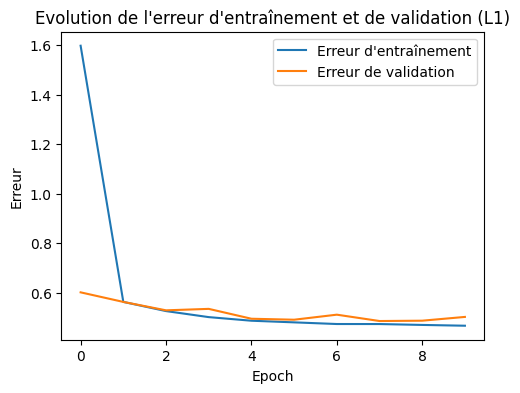

In [ ]:
# Régularisation L1
from tensorflow.keras.regularizers import l1, l2

# Créer un modèle avec régularisation L1
model_l1 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1:]), kernel_regularizer=l1(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l1(0.001)),
    Dense(len(categories), activation='softmax')
])

# Compilation du modèle avec la perte et la métrique appropriées
model_l1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les données encodées
history_l1 = model_l1.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_l1.history['loss'], label='Erreur d\'entraînement')
plt.plot(history_l1.history['val_loss'], label='Erreur de validation')
plt.xlabel('Epoch')
plt.ylabel('Erreur')
plt.legend()
plt.title('Evolution de l\'erreur d\'entraînement et de validation (L1)')
plt.show()

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7596 - loss: 0.5866 - val_accuracy: 0.8429 - val_loss: 0.3808
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8272 - loss: 0.4006 - val_accuracy: 0.8387 - val_loss: 0.3762
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8561 - loss: 0.3442 - val_accuracy: 0.8513 - val_loss: 0.3517
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8590 - loss: 0.3274 - val_accuracy: 0.8438 - val_loss: 0.3465
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8640 - loss: 0.3172 - val_accuracy: 0.8676 - val_loss: 0.3213
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8772 - loss: 0.3078 - val_accuracy: 0.8457 - val_loss: 0.3683
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8711 - loss: 0.3186 - val_accuracy: 0.8695 - val_loss: 0.3194
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8990 - loss: 0.2819 - val_accu

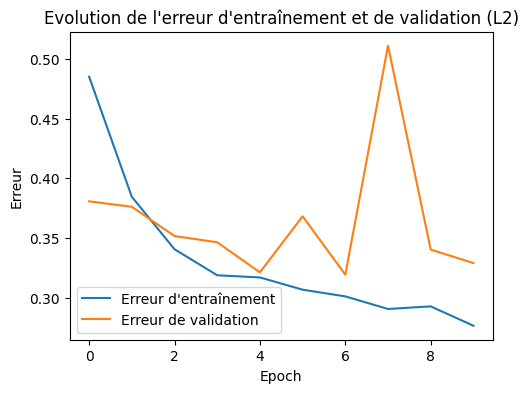

In [ ]:
# Créer un modèle avec régularisation L2
model_l2 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1:]), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(len(categories), activation='softmax')
])

# Compilation du modèle avec la perte et la métrique appropriées
model_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les données encodées
history_l2 = model_l2.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_l2.history['loss'], label='Erreur d\'entraînement')
plt.plot(history_l2.history['val_loss'], label='Erreur de validation')
plt.xlabel('Epoch')
plt.ylabel('Erreur')
plt.legend()
plt.title('Evolution de l\'erreur d\'entraînement et de validation (L2)')
plt.show()


c:\Users\danyk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7597 - loss: 5.9259 - val_accuracy: 0.7734 - val_loss: 0.9447
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - accuracy: 0.7612 - loss: 0.8916 - val_accuracy: 0.7734 - val_loss: 0.8271
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 0.7975 - loss: 0.8095 - val_accuracy: 0.8037 - val_loss: 0.8389
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - accuracy: 0.8072 - loss: 0.7974 - val_accuracy: 0.7734 - val_loss: 0.8140
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.8085 - loss: 0.7776 - val_accuracy: 0.7851 - val_loss: 0.7974
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.8067 - loss: 0.7800 - val_accuracy: 0.7674 - val_loss: 0.8113
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.8071 - loss: 0.7702 - val_accuracy: 0.8005 - val_loss: 0.7739
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.8117 - loss: 0.7538 -

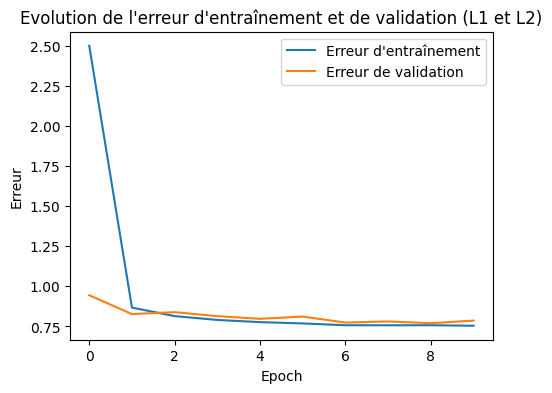

In [ ]:
from tensorflow.keras.regularizers import l1_l2

# Créer un modèle avec régularisation L1 et L2
model_l1_l2 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1:]), kernel_regularizer=l1_l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l1_l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l1_l2(0.001)),
    Dense(len(categories), activation='softmax')
])

# Compilation du modèle avec la perte et la métrique appropriées
model_l1_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les données encodées
history_l1_l2 = model_l1_l2.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_l1_l2.history['loss'], label='Erreur d\'entraînement')
plt.plot(history_l1_l2.history['val_loss'], label='Erreur de validation')
plt.xlabel('Epoch')
plt.ylabel('Erreur')
plt.legend()
plt.title('Evolution de l\'erreur d\'entraînement et de validation (L1 et L2)')
plt.show()

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7414 - loss: 0.5005 - val_accuracy: 0.8205 - val_loss: 0.3623
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8266 - loss: 0.3194 - val_accuracy: 0.8242 - val_loss: 0.3633
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8498 - loss: 0.3005 - val_accuracy: 0.8559 - val_loss: 0.2985
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8579 - loss: 0.2811 - val_accuracy: 0.8741 - val_loss: 0.2789
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8706 - loss: 0.2667 - val_accuracy: 0.8629 - val_loss: 0.2806
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8738 - loss: 0.2686 - val_accuracy: 0.8727 - val_loss: 0.2686
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8873 - loss: 0.2404 - val_accuracy: 0.8876 - val_loss: 0.2581
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9052 - loss: 0.2167 - val_accu

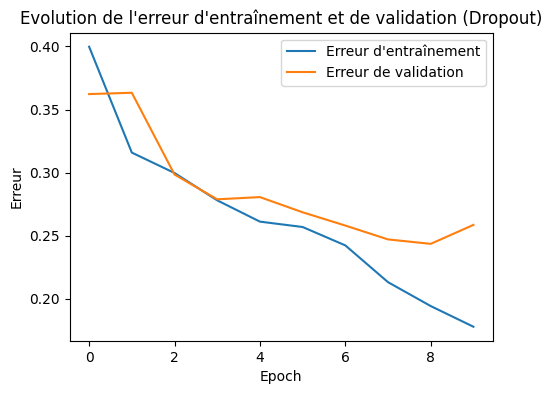

In [ ]:
from tensorflow.keras.layers import Dropout

# Créer un modèle avec dropout

model_dropout = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Désactiver 20% des neurones de la couche précédente
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.2),  # Désactiver 20% des neurones de la couche précédente
    Dense(128, activation='relu'),
    Dropout(0.2),  # Désactiver 20% des neurones de la couche précédente
    Dense(len(categories), activation='softmax')
])

# Compilation du modèle avec la perte et la métrique appropriées
model_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les données encodées
history_dropout = model_dropout.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dropout.history['loss'], label='Erreur d\'entraînement')
plt.plot(history_dropout.history['val_loss'], label='Erreur de validation')
plt.xlabel('Epoch')
plt.ylabel('Erreur')
plt.legend()
plt.title('Evolution de l\'erreur d\'entraînement et de validation (Dropout)')
plt.show()


c:\Users\danyk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.7592 - loss: 0.5985 - val_accuracy: 0.8317 - val_loss: 0.3287
Epoch 2/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.8376 - loss: 0.3187 - val_accuracy: 0.8298 - val_loss: 0.3368
Epoch 3/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - accuracy: 0.8564 - loss: 0.2959 - val_accuracy: 0.8219 - val_loss: 0.3817
Epoch 4/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.8655 - loss: 0.2788 - val_accuracy: 0.8522 - val_loss: 0.3047
Epoch 5/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - accuracy: 0.8871 - loss: 0.2567 - val_accuracy: 0.8816 - val_loss: 0.2684
Epoch 6/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - accuracy: 0.9075 - loss: 0.2128 - val_accuracy: 0.8751 - val_loss: 0.2766
Epoch 7/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - accuracy: 0.9213 - loss: 0.1851 - val_accuracy: 0.8704 - val_loss: 0.2979
Epoch 8/50
269/269 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step - accuracy: 0.9389 - loss: 0.1482 

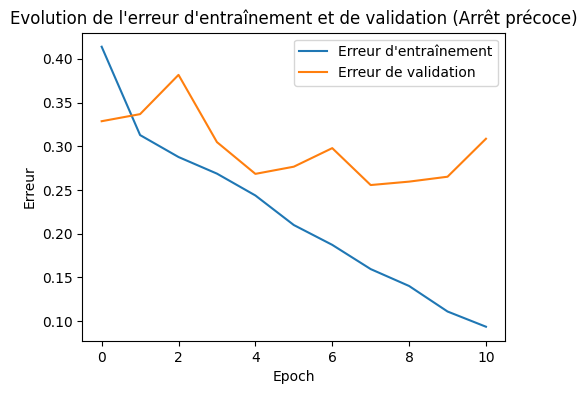

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Créer un modèle avec dropout et arrêt précoce
model_early_stopping = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(categories), activation='softmax')
])

# Compilation du modèle avec la perte et la métrique appropriées
model_early_stopping.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Définir un rappel d'arrêt précoce pour surveiller la perte de validation
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Entraînement du modèle avec les données encodées et l'arrêt précoce
history_early_stopping = model_early_stopping.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_early_stopping.history['loss'], label='Erreur d\'entraînement')
plt.plot(history_early_stopping.history['val_loss'], label='Erreur de validation')
plt.xlabel('Epoch')
plt.ylabel('Erreur')
plt.legend()
plt.title('Evolution de l\'erreur d\'entraînement et de validation (Arrêt précoce)')
plt.show()

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


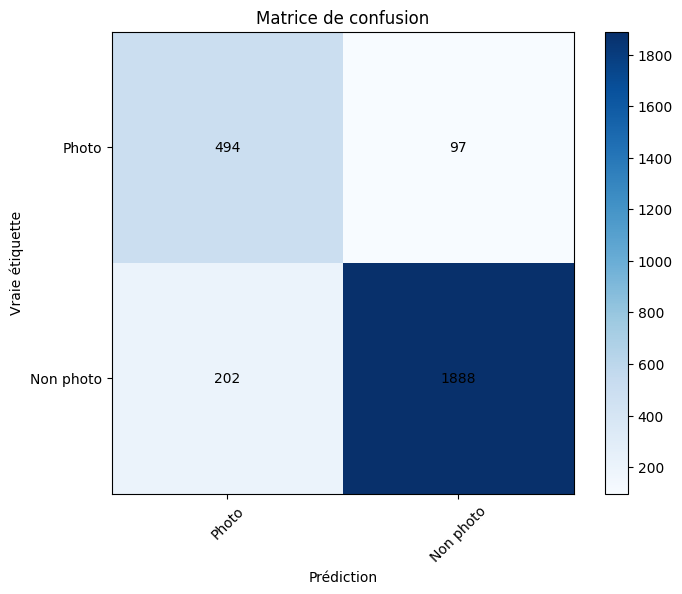

In [ ]:
y_pred = model_early_stopping.predict(X_test)
y_pred_int = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_int)

# Créer une matrice de confusion
confusion = confusion_matrix(y_test, y_pred_labels, labels=["Photo", "Non photo"])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(2), ["Photo", "Non photo"], rotation=45)
plt.yticks(np.arange(2), ["Photo", "Non photo"])
plt.xlabel('Prédiction')
plt.ylabel('Vraie étiquette')
plt.title('Matrice de confusion')
for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion[i, j], ha='center', va='center', color='black')
plt.show()

In [ ]:
def calculate_metrics(confusion_matrix):
    # Calculer les valeurs de TP, FP, TN, FN
    TP = confusion_matrix[0, 0]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]
    TN = confusion_matrix[1, 1]
    
    # Calculer la précision
    precision = TP / (TP + FP)
    
    # Calculer le rappel
    recall = TP / (TP + FN)
    
    # Calculer le score F1
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return precision, recall, f1

# Calculer les métriques de performance
precision, recall, f1 = calculate_metrics(confusion)
print("Précision :", precision)
print("Rappel :", recall)

print("Score F1 :", f1)

print("Pourcentage de photo bien prédit :", (confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])) * 100)
print("Pourcentage de non photo bien prédit :", (confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])) * 100)


Précision : 0.8358714043993232
Rappel : 0.7097701149425287
Score F1 : 0.7676767676767676
Pourcentage de photo bien prédit : 83.58714043993231
Pourcentage de non photo bien prédit : 90.33492822966507



6. Améliorations et Techniques de Régularisation
"Propose des stratégies pour améliorer les performances du modèle, comme l'application de techniques de régularisation, l'utilisation de dropout, et l'implémentation d'early stopping. Explique comment ces techniques peuvent aider à réduire le sur-apprentissage et améliorer la généralisation du modèle."
7. Conclusion et Étapes Suivantes
"Conclut le notebook en résumant les principaux résultats, en discutant la pertinence du modèle pour les objectifs de TouNum, et en suggérant des directions pour de futures améliorations ou extensions du projet de classification d'images."